In [1]:
import math
import time

import torch
import torch.nn as nn
import transformers
from modelutils import *
from quant import *


c:\Users\igor-\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\utils\_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:


DEBUG = False 

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False



In [3]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="unet", use_safetensors=True
)

In [4]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device);

In [6]:
# for layer in list(vae.encoder.modules()): print(layer)
encoder_layers = list(find_layers(vae.encoder).values())
decoder_layers = list(find_layers(vae.decoder).values())

In [7]:
encoder_layers, decoder_layers

([Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2)),
  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1)),
  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2)),
  Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1)),
 

In [8]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device = torch_device).manual_seed(0) # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [9]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [10]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [11]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [12]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

In [13]:
latents = latents * scheduler.init_noise_sigma

In [14]:
latents.shape

torch.Size([1, 4, 64, 64])

In [15]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

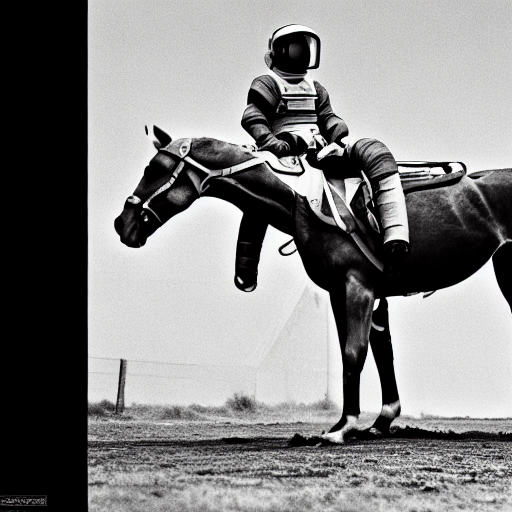

In [17]:
def img2cpu(image): 
    image = (image / 2 + 0.5).clamp(0, 1).squeeze() 
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    return image
image_cpu = Image.fromarray(img2cpu(image))
image_cpu

In [18]:
encoded_image = vae.encoder(image)
encoded_image.shape

torch.Size([1, 8, 64, 64])

In [19]:
decoded_image = vae.decoder(encoded_image[:, :4, :, :])
# out2 = vae.decoder(encoded_image[:, 4:, :, :])

In [20]:
image_cpu2 = Image.fromarray(img2cpu(decoded_image))


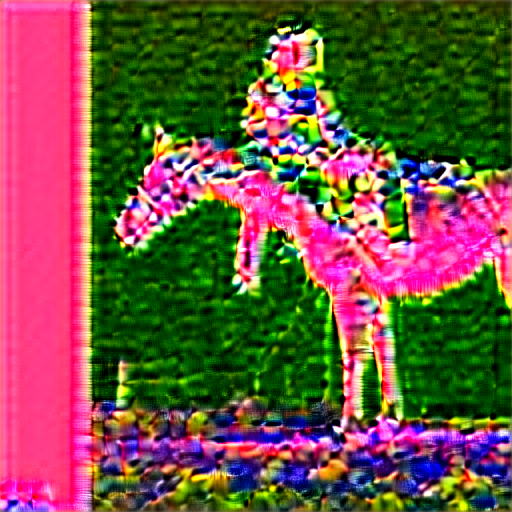

In [21]:
image_cpu2

In [16]:

class SparseGPT:

    def __init__(self, layer):
        self.layer = layer
        print(layer)
        print(type(layer))
        self.dev = self.layer.weight.device
        W = layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.rows = W.shape[0]
        self.columns = W.shape[1]
        self.H = torch.zeros((self.columns, self.columns), device=self.dev)
        self.nsamples = 0

    def add_batch(self, inp, out, blocksize=1024):
        if DEBUG:
            self.inp1 = inp
            self.out1 = out
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear) or isinstance(self.layer, transformers.Conv1D):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()
        self.H *= self.nsamples / (self.nsamples + tmp)
        self.nsamples += tmp
        inp = math.sqrt(2 / self.nsamples) * inp.float()
        self.H += inp.matmul(inp.t())

    def fasterprune(
        self, sparsity, prunen=0, prunem=0, blocksize=128, percdamp=.01
    ):
        W = self.layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        W = W.float()

        if hasattr(self, 'quantizer'):
            if not self.quantizer.ready():
                self.quantizer.find_params(W, weight=True)

        tick = time.time()

        H = self.H
        del self.H
        dead = torch.diag(H) == 0
        H[dead, dead] = 1
        W[:, dead] = 0

        Losses = torch.zeros(self.rows, device=self.dev)

        damp = percdamp * torch.mean(torch.diag(H))
        diag = torch.arange(self.columns, device=self.dev)
        H[diag, diag] += damp
        H = torch.linalg.cholesky(H)
        H = torch.cholesky_inverse(H)
        H = torch.linalg.cholesky(H, upper=True)
        Hinv = H

        mask = None

        for i1 in range(0, self.columns, blocksize):
            i2 = min(i1 + blocksize, self.columns)
            count = i2 - i1

            W1 = W[:, i1:i2].clone()
            Q1 = torch.zeros_like(W1)
            Err1 = torch.zeros_like(W1)
            Losses1 = torch.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            if prunen == 0: 
                if mask is not None:
                    mask1 = mask[:, i1:i2]
                else:
                    tmp = W1 ** 2 / (torch.diag(Hinv1).reshape((1, -1))) ** 2
                    thresh = torch.sort(tmp.flatten())[0][int(tmp.numel() * sparsity)]
                    mask1 = tmp <= thresh
            else:
                mask1 = torch.zeros_like(W1) == 1

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if prunen != 0 and i % prunem == 0:
                    tmp = W1[:, i:(i + prunem)] ** 2 / (torch.diag(Hinv1)[i:(i + prunem)].reshape((1, -1))) ** 2
                    mask1.scatter_(1, i + torch.topk(tmp, prunen, dim=1, largest=False)[1], True)

                q = w.clone()
                q[mask1[:, i]] = 0

                if hasattr(self, 'quantizer'):
                    q = quantize(
                        q.unsqueeze(1), self.quantizer.scale, self.quantizer.zero, self.quantizer.maxq
                    ).flatten()

                Q1[:, i] = q
                Losses1[:, i] = (w - q) ** 2 / d ** 2

                err1 = (w - q) / d
                W1[:, i:] -= err1.unsqueeze(1).matmul(Hinv1[i, i:].unsqueeze(0))
                Err1[:, i] = err1

            W[:, i1:i2] = Q1
            Losses += torch.sum(Losses1, 1) / 2

            W[:, i2:] -= Err1.matmul(Hinv[i1:i2, i2:])

            if DEBUG:
                self.layer.weight.data[:, :i2] = W[:, :i2]
                self.layer.weight.data[:, i2:] = W[:, i2:]
                print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))
                print(torch.sum(Losses))

        torch.cuda.synchronize()
        print('time %.2f' % (time.time() - tick))
        print('error', torch.sum(Losses).item())

        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.layer.weight.data = W.reshape(self.layer.weight.shape).to(self.layer.weight.data.dtype)
        if DEBUG:
            print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))

    def free(self):
        if DEBUG:
            self.inp1 = None
            self.out1 = None
        self.H = None
        torch.cuda.empty_cache()


In [33]:
sgpt = SparseGPT(encoder_layers[0])

Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<class 'torch.nn.modules.conv.Conv2d'>


In [35]:
sgpt.fasterprune(0.1)

AttributeError: 'SparseGPT' object has no attribute 'H'